# Delete the counties with insufficient yield data

In [1]:
import pandas as pd

# Load the Excel file
file_path = 'Corm Yield 1982-2022.xlsx'
df = pd.read_excel(file_path)

# Remove rows with 20 or more empty cells
df_cleaned = df.dropna(thresh=df.shape[1] - 20)

# Save the cleaned data back to a new Excel file (optional)
output_file_path = '!Corn_Yield_1982-2022.xlsx'
df_cleaned.to_excel(output_file_path, index=False)

# Display the cleaned data (optional)
print(df_cleaned)


           State+county        1982        1983        1984        1985  \
0      Alabama, Autauga  3974.54001  2555.54180  2770.74532  3799.68715   
1      Alabama, Baldwin  6355.22895  6402.30472  5279.21135  5380.08800   
2      Alabama, Barbour  4371.32150  3819.86248  3792.96204  4236.81930   
4       Alabama, Blount  4633.60079  2400.86427  3792.96204  6166.92587   
6       Alabama, Butler  3806.41226  2972.49862  3618.10918  3483.60698   
...                 ...         ...         ...         ...         ...   
2616    Wyoming, Goshen  7343.82012  7431.24655  7088.26594  6725.11000   
2619   Wyoming, Laramie  6140.02543  6792.36110  6523.35670  6321.60340   
2622      Wyoming, Park  5581.84130  6187.10120  6187.10120  6187.10120   
2623    Wyoming, Platte  6994.11440  6388.85450  6052.59900  6207.27653   
2625  Wyoming, Washakie  7088.26594  7195.86770  7464.87210  6725.11000   

            1986        1987        1988        1989        1990  ...  \
0     2589.16735  3207.877

# Separate data by state

In [2]:
import pandas as pd

# Read the CSV file
file_path = '!CY_spi3_1982-2022.csv'
data = pd.read_csv(file_path)

# Group by the 'State' column and save each state's data to a separate file
for state, group in data.groupby('State'):
    # Define the output file name based on the state name
    output_file = f'{state}_CY_spi3_1982-2022.csv'
    
    # Save the state's data to the output CSV file
    group.to_csv(output_file, index=False)
    print(f'Saved: {output_file}')

Saved: Alabama_CY_spi3_1982-2022.csv
Saved: Arizona_CY_spi3_1982-2022.csv
Saved: Arkansas_CY_spi3_1982-2022.csv
Saved: California_CY_spi3_1982-2022.csv
Saved: Colorado_CY_spi3_1982-2022.csv
Saved: Delaware_CY_spi3_1982-2022.csv
Saved: Florida_CY_spi3_1982-2022.csv
Saved: Georgia_CY_spi3_1982-2022.csv
Saved: Idaho_CY_spi3_1982-2022.csv
Saved: Illinois_CY_spi3_1982-2022.csv
Saved: Indiana_CY_spi3_1982-2022.csv
Saved: Iowa_CY_spi3_1982-2022.csv
Saved: Kansas_CY_spi3_1982-2022.csv
Saved: Kentucky_CY_spi3_1982-2022.csv
Saved: Louisiana_CY_spi3_1982-2022.csv
Saved: Maryland_CY_spi3_1982-2022.csv
Saved: Michigan_CY_spi3_1982-2022.csv
Saved: Minnesota_CY_spi3_1982-2022.csv
Saved: Mississippi_CY_spi3_1982-2022.csv
Saved: Missouri_CY_spi3_1982-2022.csv
Saved: Montana_CY_spi3_1982-2022.csv
Saved: Nebraska_CY_spi3_1982-2022.csv
Saved: New Jersey_CY_spi3_1982-2022.csv
Saved: New Mexico_CY_spi3_1982-2022.csv
Saved: New York_CY_spi3_1982-2022.csv
Saved: North Carolina_CY_spi3_1982-2022.csv
Saved: Nor

# Filter the yield loss that was not caused by drought

In [1]:
import pandas as pd

# Define input files for states
input_files = [
    'Illinois_CY_spi3_1982-2022.csv',
    'Indiana_CY_spi3_1982-2022.csv',
    'Iowa_CY_spi3_1982-2022.csv',
    'Ohio_CY_spi3_1982-2022.csv'
]

# Iterate over each input file
for file_path in input_files:
    # Load the CSV file
    data = pd.read_csv(file_path)
    
    # Determine the SPI column suffix based on the state
    state = file_path.split('_')[0]  # Extract state name from the filename
    spi_suffix = '-09' if state == 'Iowa' else '-08'  # Iowa uses September, others use August
    
    # Calculate the average corn yield for the period 1982-2022 for each county
    yield_years = list(map(str, range(1982, 2022 + 1)))
    data['CY avg'] = data[yield_years].mean(axis=1)

    # Create filter columns for each year from 1982 to 2022
    for year in range(1982, 2023):
        yield_column = str(year)
        spi_column = f'{year}{spi_suffix}'  # Adjust SPI column based on the state
        filter_column = f'Filter {year}'

        # Initialize the filter column
        data[filter_column] = 1

        # Update the filter column based on the conditions
        data.loc[(data[yield_column] < data['CY avg']) & (data[spi_column] > 1), filter_column] = 0

    # Delete corn yield data corresponding to 0 values in filter columns
    for year in range(1982, 2023):
        yield_column = str(year)
        filter_column = f'Filter {year}'

        # Set the corn yield data to NaN where the filter column is 0
        data.loc[data[filter_column] == 0, yield_column] = None

    # Save the updated dataframe to a new CSV file
    output_file_path = file_path.replace('.csv', '_filtered.csv')
    data.to_csv(output_file_path, index=False)

    print(f"Processing for {state} complete. Filtered data saved to {output_file_path}.")


Processing for Illinois complete. Filtered data saved to Illinois_CY_spi3_1982-2022_filtered.csv.
Processing for Indiana complete. Filtered data saved to Indiana_CY_spi3_1982-2022_filtered.csv.
Processing for Iowa complete. Filtered data saved to Iowa_CY_spi3_1982-2022_filtered.csv.
Processing for Ohio complete. Filtered data saved to Ohio_CY_spi3_1982-2022_filtered.csv.


# Detrend the WY using OLS

In [3]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

# List of input files (corn yield and SPI data for various states)
input_files = [
    'Illinois_CY_spi3_1982-2022_filtered.csv',
    'Indiana_CY_spi3_1982-2022_filtered.csv',
    'Iowa_CY_spi3_1982-2022_filtered.csv',
    'Ohio_CY_spi3_1982-2022_filtered.csv',
]

# Define the column frame for detrending
columns_to_detrend = [str(year) for year in range(1982, 2023)]

# Function to detrend corn yield data using linear regression, handling missing values
def detrend_row(row):
    # Drop missing values
    not_nan_mask = ~np.isnan(row)
    X = np.arange(len(row))[not_nan_mask].reshape(-1, 1)
    y = row[not_nan_mask].values.reshape(-1, 1)
    
    if len(X) > 1:  # Need at least two points to fit a line
        lr = LinearRegression()
        lr.fit(X, y)
        trend = lr.predict(np.arange(len(row)).reshape(-1, 1)).flatten()
    else:
        trend = np.zeros(len(row))  # If not enough data, set trend to zero
    
    detrended = row.values - trend
    return detrended

# Iterate over each input file
for file in input_files:
    # Load the filled CSV file
    df = pd.read_csv(file)
    
    # Detrend corn yield data horizontally for each row
    detrended_data = df[columns_to_detrend].apply(detrend_row, axis=1)

    # Create new column names for detrended values
    detrended_columns = [f"DY{year}" for year in range(1982, 2023)]

    # Assign detrended values to new columns
    df[detrended_columns] = pd.DataFrame(detrended_data.tolist(), index=detrended_data.index)

    # Save the dataframe with detrended values to a new CSV file
    output_file = file.split('.')[0] + '_detrended.csv'
    df.to_csv(output_file, index=False)

# Corn yield and SPI-3 correlation by months

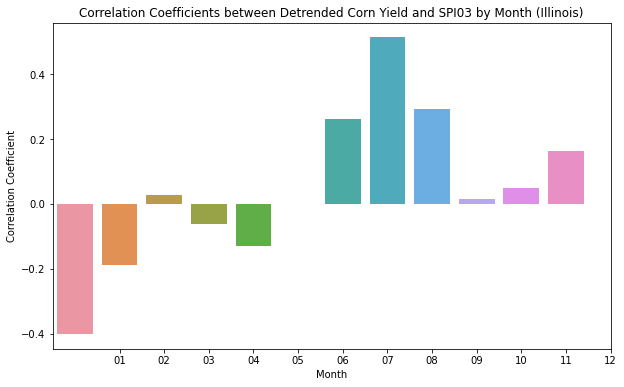

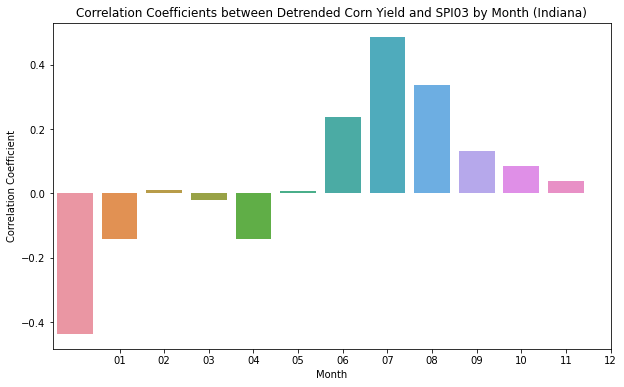

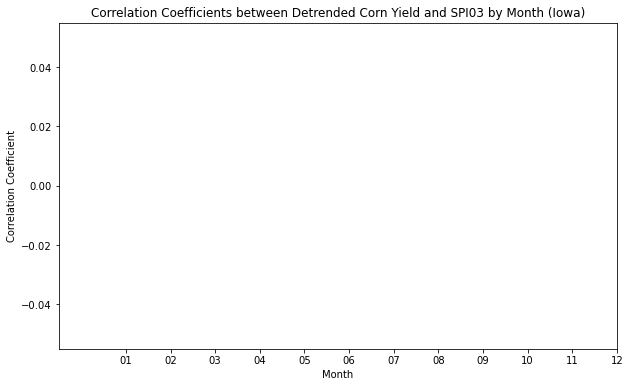

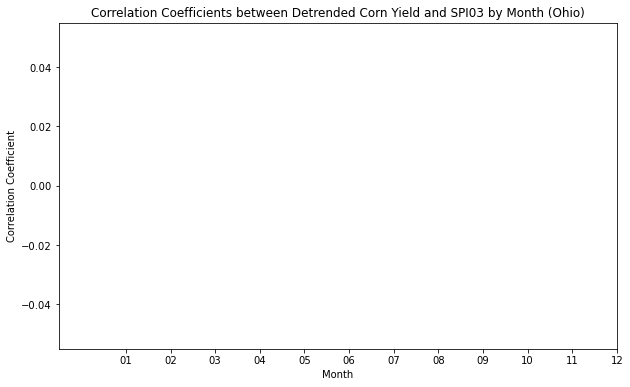

Correlation results saved to 'correlation_results.csv'.


In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# List of filtered data files
input_files = [
    'Illinois_CY_spi3_1982-2022_filtered_detrended.csv',
    'Indiana_CY_spi3_1982-2022_filtered_detrended.csv',
    'Iowa_CY_spi3_1982-2022_filtered_detrended.csv',
    'Ohio_CY_spi3_1982-2022_filtered_detrended.csv',
]

# Initialize a list to store the results
results_list = []

# Iterate over each input file
for file in input_files:
    try:
        # Load the dataset
        df = pd.read_csv(file)
    except FileNotFoundError:
        print(f"File {file} not found.")
        continue

    # Extract the state name from the filename
    state = file.split('_')[0]

    # Initialize lists to store correlation coefficients and months
    correlation_coefficients = []
    months = list(range(1, 13))

    # Iterate over each month from January to December
    for month in months:
        # Form the column names for SPI03 data for the current month
        spi03_columns = [f"{year}-{month:02d}" for year in range(1982, 2023)]
        # Form the column names for detrended corn yield
        yield_columns = [f"DY{year}" for year in range(1982, 2023)]

        # Combine yield columns and SPI03 columns into a single DataFrame
        yield_df = df[yield_columns]
        spi03_df = df[spi03_columns]

        # Align both datasets by dropping rows with missing values
        combined_df = pd.concat([yield_df, spi03_df], axis=1)
        combined_df = combined_df.dropna()

        if not combined_df.empty:
            # Extract data for current month
            yield_data = combined_df[yield_columns].values.flatten()
            spi03_data = combined_df[spi03_columns].values.flatten()

            # Calculate the correlation coefficient
            correlation_coefficient = np.corrcoef(yield_data, spi03_data)[0, 1]
        else:
            correlation_coefficient = np.nan  # No valid data for this month

        # Store correlation coefficient and month
        correlation_coefficients.append(correlation_coefficient)

        # Append the result to the results_list
        results_list.append({'State': state, 'Month': month, 'Correlation': correlation_coefficient})

    # Plot the correlation coefficients
    plt.figure(figsize=(10, 6))
    sns.barplot(x=months, y=correlation_coefficients)
    plt.title(f'Correlation Coefficients between Detrended Corn Yield and SPI03 by Month ({state})')
    plt.xlabel('Month')
    plt.ylabel('Correlation Coefficient')
    plt.xticks(ticks=months, labels=[f'{month:02d}' for month in months])  # Add month labels
    plt.show()

# Convert the list of results into a DataFrame
results_df = pd.DataFrame(results_list)

# Save results to a CSV file for future reference
results_df.to_csv('correlation_results.csv', index=False)

print("Correlation results saved to 'correlation_results.csv'.")

# Corn yield and SPI-3 scatterplots for the month with highest correlation

           Month_1   Month_2   Month_3   Month_4   Month_5   Month_6  \
Illinois -0.264293 -0.177765  0.027389  0.010696 -0.042405  0.051720   
Indiana  -0.264307 -0.139906  0.010013 -0.054298 -0.092317  0.084224   
Iowa     -0.051669 -0.015602  0.067754 -0.007530 -0.023358  0.020071   
Ohio     -0.111876 -0.119630 -0.029970 -0.053594 -0.035638  0.106132   

           Month_7   Month_8   Month_9  Month_10  Month_11  Month_12  
Illinois  0.354055  0.480700  0.351752  0.087882  0.075517  0.146014  
Indiana   0.359906  0.509577  0.356209  0.065674  0.053657  0.047894  
Iowa      0.272167  0.395181  0.433378  0.253403  0.104842  0.077324  
Ohio      0.305928  0.472212  0.302924  0.060715  0.023675  0.038637  


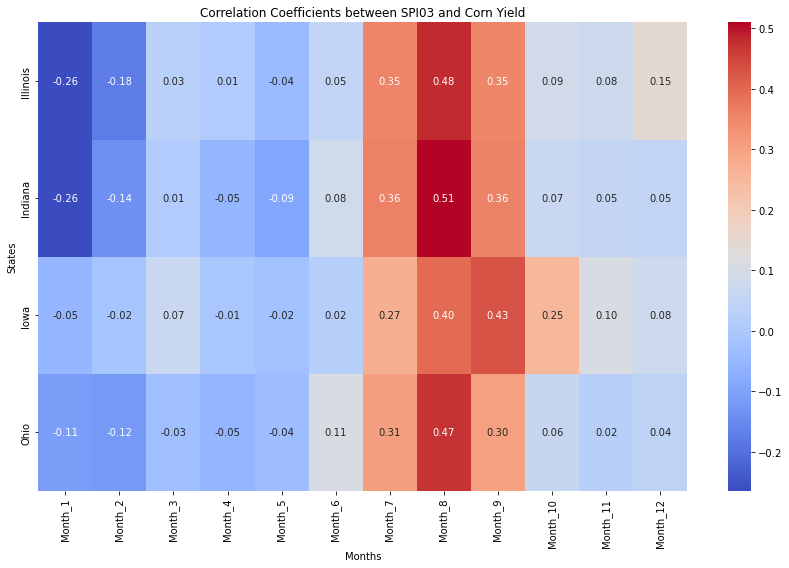

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define a function to process data and calculate correlation coefficients for each month
def process_and_plot_data(file_name, state_name):
    # Load the CSV file
    df = pd.read_csv(file_name)

    # Initialize a dictionary to store correlation coefficients for each month
    correlation_coefficients = {}

    # Loop through each month (1 to 12) and process the data
    for spi_month in range(1, 13):
        # Initialize lists to store plot data
        yield_data = []
        spi03_data = []
        
        # Extract data for the current month (spi_month) from each year
        for year in range(1982, 2023):
            yield_column_name = f"DY{year}"
            spi03_column_name = f"{year}-{spi_month:02}"
            
            # Check if both columns are in the dataframe
            if yield_column_name in df and spi03_column_name in df:
                yield_data.extend(df[yield_column_name].tolist())
                spi03_data.extend(df[spi03_column_name].tolist())

        # Ensure there are non-empty values for correlation calculation
        yield_data = np.array(yield_data)
        spi03_data = np.array(spi03_data)
        non_empty_indices = ~np.isnan(yield_data) & ~np.isnan(spi03_data)
        
        if np.any(non_empty_indices):  # Check if there are any True values in non_empty_indices
            correlation_coefficient = np.corrcoef(spi03_data[non_empty_indices],
                                                  yield_data[non_empty_indices])[0, 1]
        else:
            correlation_coefficient = np.nan
        
        # Store the correlation coefficient for the current month
        correlation_coefficients[spi_month] = correlation_coefficient

    # Return the correlation coefficients for the state
    return state_name, correlation_coefficients

# List of states and their respective file names
states_data = [
    ('Illinois', 'Illinois_CY_spi3_1982-2022_filtered_detrended.csv'),
    ('Indiana', 'Indiana_CY_spi3_1982-2022_filtered_detrended.csv'),
    ('Iowa', 'Iowa_CY_spi3_1982-2022_filtered_detrended.csv'),
    ('Ohio', 'Ohio_CY_spi3_1982-2022_filtered_detrended.csv'),
]

# Initialize a DataFrame to store correlation coefficients for all states and months
all_correlation_data = pd.DataFrame(columns=[f'Month_{i}' for i in range(1, 13)])

# Process and store correlation coefficients for each state
for state_name, file_name in states_data:
    state, correlations = process_and_plot_data(file_name, state_name)
    # Append the state's correlations to the DataFrame
    all_correlation_data.loc[state] = list(correlations.values())

# Display the DataFrame with correlation coefficients for all states and months
print(all_correlation_data)

# Optionally, plot a heatmap of the correlation coefficients
plt.figure(figsize=(12, 8))
sns.heatmap(all_correlation_data.astype(float), annot=True, cmap="coolwarm", cbar=True, fmt=".2f")
plt.title("Correlation Coefficients between SPI03 and Corn Yield")
plt.xlabel("Months")
plt.ylabel("States")
plt.tight_layout()
plt.show()
  

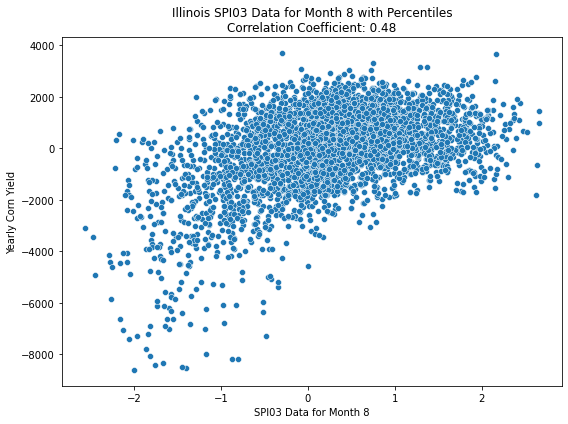

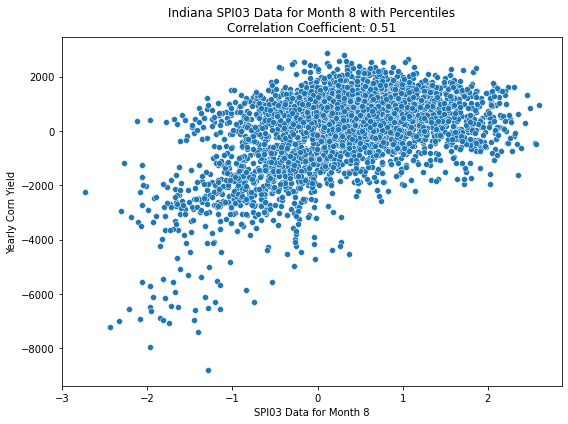

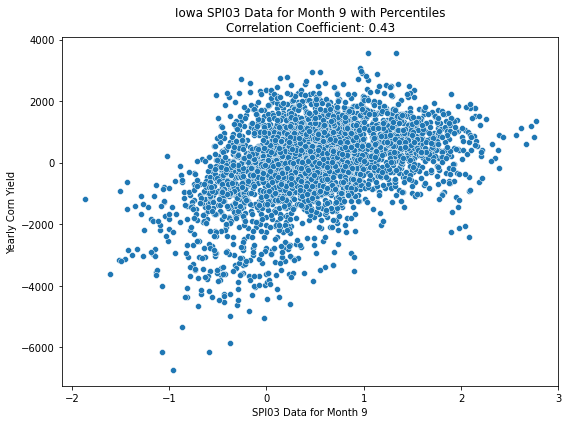

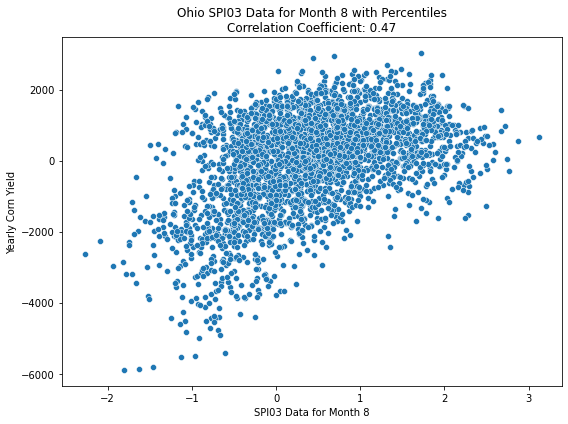

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define a function to process data and plot for each state
def process_and_plot_data(file_name, month, spi_month, state_name):
    # Load the CSV file
    df = pd.read_csv(file_name)

    # Extract columns for August (month 08) for yearly corn yield data
    yield_columns = df.loc[:, '1982':'2022']

    # Initialize lists to store plot data
    plot_data = []

    # Extract data for August from each year
    yield_data = []
    spi03_data = []
    for year in range(1982, 2022):
        yield_column_name = f"DY{year}"
        yield_data.extend(df[yield_column_name])
        spi03_column_name = f"{year}-{spi_month:02}"
        spi03_data.extend(df[spi03_column_name])

    plot_data.append({'Month': month, 'Yield': yield_data, 'SPI03': spi03_data})

    # Calculate correlation coefficient, dropping empty cells
    non_empty_indices = ~np.isnan(yield_data) & ~np.isnan(spi03_data)
    correlation_coefficient = np.corrcoef(np.array(spi03_data)[non_empty_indices],
                                          np.array(yield_data)[non_empty_indices])[0, 1]

    # Plot the scatter plot for August with horizontal dotted lines at specified percentiles
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=plot_data[0]['SPI03'], y=plot_data[0]['Yield'])  # Swapping x and y axes

    plt.title(f'{state_name} SPI03 Data for Month {spi_month} with Percentiles\nCorrelation Coefficient: {correlation_coefficient:.2f}')
    plt.xlabel(f'SPI03 Data for Month {spi_month}')  # Labeling x-axis with SPI month
    plt.ylabel('Yearly Corn Yield')  # Labeling y-axis as Yearly Corn Yield

    plt.tight_layout()
    plt.show()

# List of states and their respective file names, months, and SPI03 months
states_data = [
    ('Illinois', 'Illinois_CY_spi3_1982-2022_filtered_detrended.csv', 8,8),
    ('Indiana', 'Indiana_CY_spi3_1982-2022_filtered_detrended.csv', 8,8),
    ('Iowa', 'Iowa_CY_spi3_1982-2022_filtered_detrended.csv', 9,9),
    ('Ohio', 'Ohio_CY_spi3_1982-2022_filtered_detrended.csv', 8,8),
]

# Process and plot data for each state
for state_name, file_name, month, spi_month in states_data:
    process_and_plot_data(file_name, month, spi_month, state_name)

# Scatterplots of August below the 20th percentile

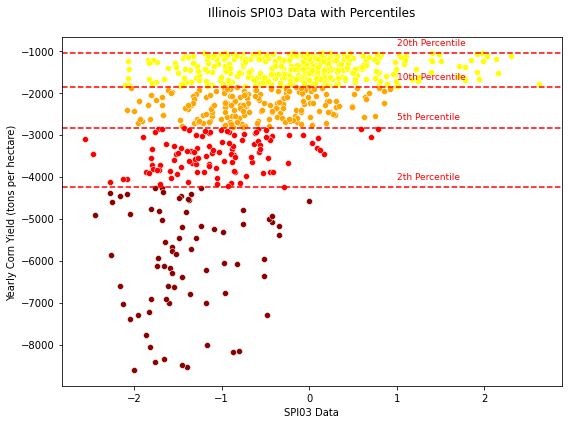

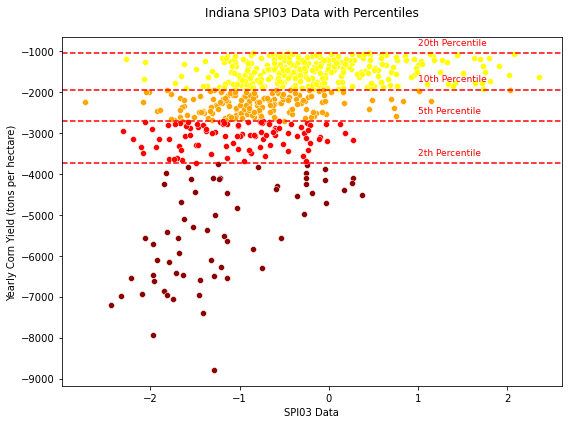

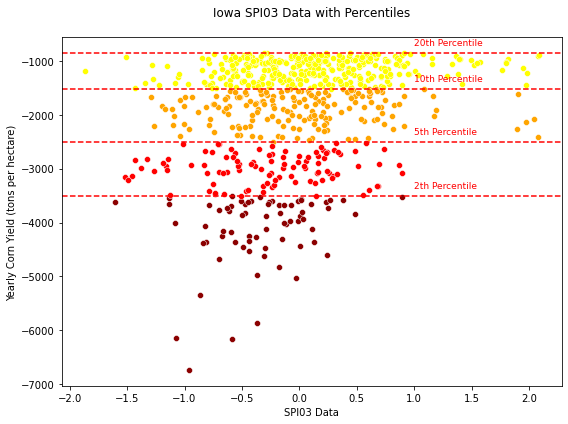

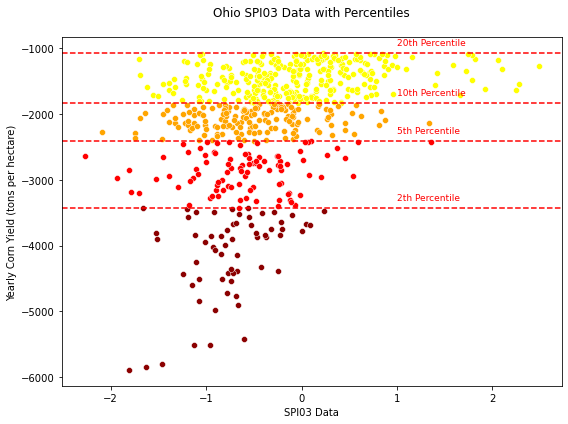

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define function to plot SPI03 data with percentiles for each region
def plot_spi03_with_percentiles(file_name, month_name):
    # Load the CSV file
    df = pd.read_csv(file_name)

    # Extract columns for specified month (e.g., August - month 08) for yearly corn yield data
    yield_columns = df.loc[:, '1982':'2022']

    # Initialize lists to store plot data
    plot_data = []

    # Extract data for specified month from each year
    yield_data_month = []
    spi03_data_month = []
    for year in range(1982, 2023):
        yield_column_name = f"DY{year}"
        yield_data_month.extend(df[yield_column_name])
        spi03_column_name = f"{year}-{month_name}"
        spi03_data_month.extend(df[spi03_column_name])

    plot_data.append({'Month': int(month_name), 'Yield': yield_data_month, 'SPI03': spi03_data_month})

    # Calculate correlation coefficient, dropping empty cells
    non_empty_indices = ~np.isnan(yield_data_month) & ~np.isnan(spi03_data_month)
    correlation_coefficient = np.corrcoef(np.array(spi03_data_month)[non_empty_indices],
                                          np.array(yield_data_month)[non_empty_indices])[0, 1]

    # Calculate desired percentiles of the yield data
    percentiles = [2, 5, 10, 20]
    yield_percentiles = np.percentile(np.array(yield_data_month)[non_empty_indices], percentiles)

    # Plot the scatter plot for the specified month with horizontal dotted lines at specified percentiles
    plt.figure(figsize=(8, 6))

    # Filter data below the 2th percentile
    below_2th_percentile_indices = np.array(yield_data_month) <= yield_percentiles[0]
    spi03_below_2th_percentile = np.array(spi03_data_month)[below_2th_percentile_indices]
    yield_below_2th_percentile = np.array(yield_data_month)[below_2th_percentile_indices]

    sns.scatterplot(x=spi03_below_2th_percentile, y=yield_below_2th_percentile, color='darkred')

    # Filter data above the 20th percentile
    below_20th_percentile_indices = np.array(yield_data_month) <= yield_percentiles[-1]
    spi03_below_20th = np.array(spi03_data_month)[below_20th_percentile_indices]
    yield_below_20th = np.array(yield_data_month)[below_20th_percentile_indices]

    # Add coloration for different percentile ranges
    for p in range(len(percentiles) - 1, 0, -1):
        lower_percentile = yield_percentiles[p]
        upper_percentile = yield_percentiles[p - 1]
        indices = (yield_below_20th > upper_percentile) & (yield_below_20th <= lower_percentile)
        sns.scatterplot(x=spi03_below_20th[indices], y=yield_below_20th[indices], color=['red', 'orange', 'yellow', 'darkred'][p - 1])

    for percentile, value in zip(yield_percentiles, percentiles):
        plt.axhline(y=percentile, linestyle='--', color='red')  # Horizontal lines at percentiles
        plt.annotate(f'{value}th Percentile', xy=(1, percentile), xytext=(0, 6),
                     textcoords='offset points', ha='left', va='bottom', color='red', fontsize=9)

    # Extract state name from the file name
    state_name = file_name.split('_')[0]

    plt.title(f'{state_name} SPI03 Data with Percentiles\n')
    plt.xlabel('SPI03 Data')  # Labeling x-axis as SPI03 Data
    plt.ylabel('Yearly Corn Yield (tons per hectare)')  # Labeling y-axis as Yearly Corn Yield

    plt.tight_layout()
    plt.show()

# List of file names for each region
file_names = [
    ('Illinois_CY_spi3_1982-2022_filtered_detrended.csv'),
    ('Indiana_CY_spi3_1982-2022_filtered_detrended.csv'),
    ('Iowa_CY_spi3_1982-2022_filtered_detrended.csv'),
    ('Ohio_CY_spi3_1982-2022_filtered_detrended.csv'),
]

# List of months corresponding to SPI03 data
months = ['08', '08', '09', '08']

# Plot SPI03 data with percentiles for each region
for file_name, month_name in zip(file_names, months):
    plot_spi03_with_percentiles(file_name, month_name)

# Aggregate the data

In [9]:
import pandas as pd
import numpy as np

# Define a function to process data for each state
def process_state_data(state_name, month):
    # Define the list of CSV file names
    file_name = f'{state_name}_CY_spi3_1982-2022_filtered_detrended.csv'

    # Load the CSV file
    df = pd.read_csv(file_name)

    # Initialize lists to store plot data
    plot_data = []

    # Calculate desired percentiles of the yield data
    percentiles = [2, 5, 10, 20]

    # Extract columns for the specified month for yearly corn yield data
    yield_columns = df.loc[:, '1982':'2022']

    # Extract data for the specified month from each year
    yield_data_month = []
    spi03_data_month = []
    for year in range(1982, 2023):
        yield_column_name = f"DY{year}" 
        yield_data_month.extend(df[yield_column_name])
        spi03_column_name = f"{year}-{month:02}"
        spi03_data_month.extend(df[spi03_column_name])

    # Filter data based on desired percentiles
    non_empty_indices = ~np.isnan(yield_data_month) & ~np.isnan(spi03_data_month)
    yield_percentiles = np.percentile(np.array(yield_data_month)[non_empty_indices], percentiles)

    # Store the filtered data
    filtered_yield_data = np.array(yield_data_month)[non_empty_indices]
    filtered_spi03_data = np.array(spi03_data_month)[non_empty_indices]

    region_data = {'Filtered_Yield': filtered_yield_data, 'Filtered_SPI03': filtered_spi03_data}
    plot_data.append(region_data)

    # Construct the new output filename
    output_filename = f"{state_name}_CY_spi3_1982-2022_filtered_detrended_aggregated.csv"
    
    # Save filtered data to the new CSV file
    filtered_df = pd.DataFrame({'Yearly_Corn_Yield': filtered_yield_data, 'SPI03_Data': filtered_spi03_data})
    filtered_df.to_csv(output_filename, index=False)

    print(f"Filtered data for {state_name} saved to {output_filename}.")

# Example of processing each state's data
process_state_data('Illinois', 8)
process_state_data('Indiana', 8)
process_state_data('Iowa', 9)
process_state_data('Ohio', 8)

Filtered data for Illinois saved to Illinois_CY_spi3_1982-2022_filtered_detrended_aggregated.csv.
Filtered data for Indiana saved to Indiana_CY_spi3_1982-2022_filtered_detrended_aggregated.csv.
Filtered data for Iowa saved to Iowa_CY_spi3_1982-2022_filtered_detrended_aggregated.csv.
Filtered data for Ohio saved to Ohio_CY_spi3_1982-2022_filtered_detrended_aggregated.csv.


# Create boxplots

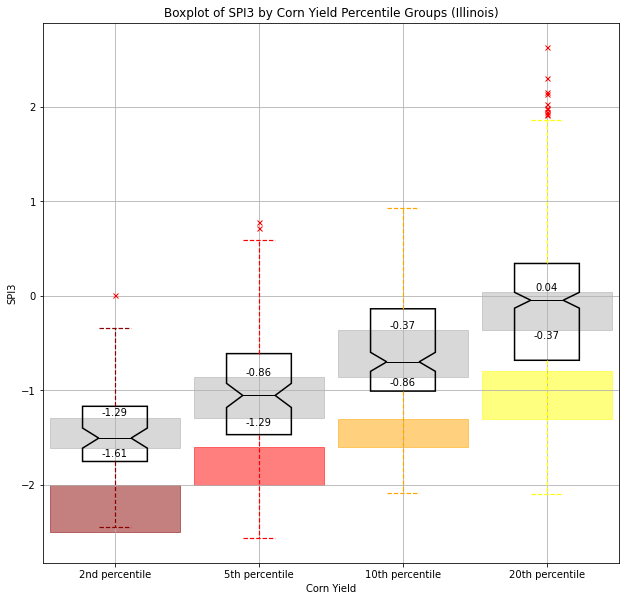

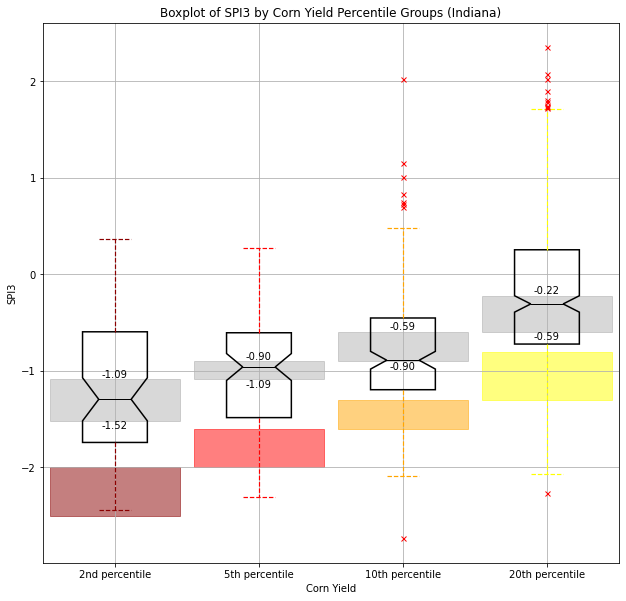

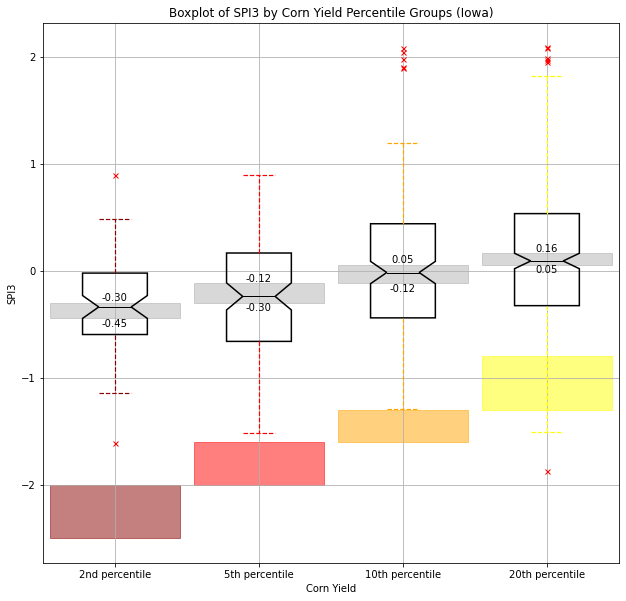

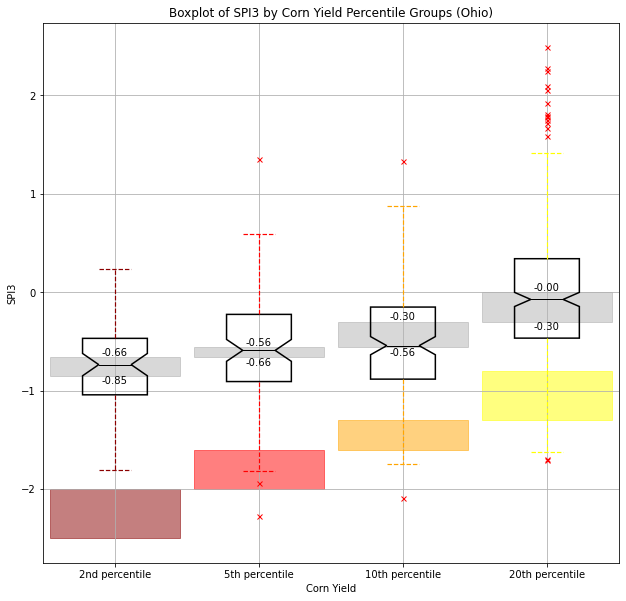

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define the list of regions and their respective filenames
regions = [
'Illinois', 'Indiana', 'Iowa', 'Ohio'
]

filenames = [
   'Illinois_CY_spi3_1982-2022_filtered_detrended_aggregated.csv', 'Indiana_CY_spi3_1982-2022_filtered_detrended_aggregated.csv', 
   'Iowa_CY_spi3_1982-2022_filtered_detrended_aggregated.csv', 'Ohio_CY_spi3_1982-2022_filtered_detrended_aggregated.csv'
]

# Define color-coded bar ranges for each group
bar_ranges = {'D1': (-0.8, -1.3), 'D2': (-1.3, -1.6), 'D3': (-1.6, -2), 'D4': (-2, -2.5)}

# Iterate over each region and its filename
for region, filename in zip(regions, filenames):
    # Read the detrended CSV file
    data = pd.read_csv(filename)

    # Access the SPI03_Data column from detrended data
    spi_data = data['SPI03_Data']

    # Calculate percentiles of 'Yearly_Corn_Yield' column from detrended data
    percentiles_yield = np.percentile(data['Yearly_Corn_Yield'], [2, 5, 10, 20])

    # Define groups based on percentiles
    group_labels = ['D4', 'D3', 'D2', 'D1']
    data['Group'] = pd.cut(data['Yearly_Corn_Yield'], bins=[-np.inf, *percentiles_yield], labels=group_labels, right=False)

    # Create custom color map for the groups
    colors = {'D1': 'yellow', 'D2': 'orange', 'D3': 'red', 'D4': 'darkred'}

    # Create figure and axes objects
    fig, ax = plt.subplots(figsize=(10, 10))  # Specify the size here

    # Custom boxplot styling
    boxprops = dict(color='black', linestyle='--', linewidth=1.5, facecolor='none')
    medianprops = dict(color='black', linewidth=1)
    whiskerprops = dict(color='black', linestyle='--', linewidth=1.5)
    capprops = dict(color='black', linewidth=5)
    flierprops = dict(marker='x', markeredgecolor='red', markersize=5)  # Assign red color to outliers

    boxplot = data.boxplot(column='SPI03_Data', by='Group', patch_artist=True, ax=ax,
                                     boxprops=boxprops, medianprops=medianprops,
                                     whiskerprops=whiskerprops, capprops=capprops,
                                     flierprops=flierprops, notch=True)  # Add notches

    # Customizing box colors and styles
    for i, artist in enumerate(boxplot.artists):
        color = colors[group_labels[i]]
        # Set edge color for the box
        artist.set_edgecolor(color)  # Set edge color to match face color

        # Find the corresponding box elements and set linestyle and linewidth
        for j in range(i * 6, (i + 1) * 6):  # Indices of box elements (box, whiskers, caps)
            boxplot.lines[j].set_color(color)
            boxplot.lines[j].set_linestyle('-')
            boxplot.lines[j].set_linewidth(1)

    # Customizing line between min and max values and caps
    for i in range(len(group_labels)):
        color = colors[group_labels[i]]
        lines = boxplot.lines[i * 6: i * 6 + 4]  # Lines for whiskers and caps
        for line in lines:
            line.set_color(color)
            line.set_linestyle('--')
            line.set_linewidth(1.2)

    # Calculate notch values for each group
    notch_values = {}
    for label in group_labels:
        group_data = data[data['Group'] == label]['SPI03_Data']
        n = len(group_data)
        q2 = np.percentile(group_data, [50])[0]  # Median (Q2)
        q1, q3 = np.percentile(group_data, [25, 75])
        iqr = q3 - q1
        notch = 1.57 * (iqr / np.sqrt(n))
        lower_notch = q2 - notch  # Using Q2 instead of Q1
        upper_notch = q2 + notch
        notch_values[label] = (lower_notch, upper_notch)

    # Substitute the values accordingly
    impact_thresholds = {
        'D4': (notch_values['D4'][0], (notch_values['D4'][1] + notch_values['D3'][0]) / 2),
        'D3': ((notch_values['D4'][1] + notch_values['D3'][0]) / 2, (notch_values['D3'][1] + notch_values['D2'][0]) / 2),
        'D2': ((notch_values['D3'][1] + notch_values['D2'][0]) / 2, (notch_values['D2'][1] + notch_values['D1'][0]) / 2),
        'D1': ((notch_values['D2'][1] + notch_values['D1'][0]) / 2, notch_values['D1'][1])
    }

    # Add impact threshold values
    for label in group_labels:
        lower, upper = impact_thresholds[label]
        x_position = group_labels.index(label) + 1
        ax.text(x_position, lower, f'{lower:.2f}', ha='center', va='top', color='black')
        ax.text(x_position, upper, f'{upper:.2f}', ha='center', va='bottom', color='black')

    # Update the height range of grey-shaded bars/columns
    for label in group_labels:
        lower, upper = impact_thresholds[label]
        x_position = group_labels.index(label) + 1
        ax.fill_between([x_position - 0.45, x_position + 0.45], lower, upper, color='grey', alpha=0.3)

    # Add color-coded bars to each group
    for label in group_labels:
        x_position = group_labels.index(label) + 1
        lower, upper = bar_ranges[label]
        ax.fill_between([x_position - 0.45, x_position + 0.45], lower, upper, color=colors[label], alpha=0.5)

    # Update x-axis ticks and labels
    ax.set_xticks(range(1, len(group_labels) + 1))
    ax.set_xticklabels(['2nd percentile', '5th percentile', '10th percentile', '20th percentile'])

    plt.title(f'Boxplot of SPI3 by Corn Yield Percentile Groups ({region})')
    plt.suptitle('')
    plt.xlabel('Corn Yield')
    plt.ylabel('SPI3')
    plt.show()

# Apply the impact-based thresholds to SPI03 maps